In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.datasets import load_breast_cancer, fetch_california_housing, load_diabetes
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from scipy.stats import spearmanr, pearsonr

import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold


In [2]:
path_arakawa = "C:/Users/46705/Documents/SpiderSilk/data/post_filtering/arakawa_ara.csv"
arakawa = pd.read_csv(path_arakawa, sep= ",")


In [3]:
def evaluate_regression(y_test, y_pred):
    r2 = r2_score(y_test, y_pred)
    print("R2 Score:", r2)

    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red')  # Diagonal line
    plt.xlabel('Actual Values (y_test)')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs. Predicted Values')
    plt.grid(True)
    plt.show()

In [4]:
def RF_hold_out(df, prop, depth, estimators, test_size, seed, mtry, n_loop=None, spidroin = False): 
    
    features_df = df.iloc[4:, 7:-29]
    properties_df = df.iloc[4:,:][[prop]]

    X = np.array(features_df)
    y = np.array(properties_df)
    features = features_df.columns
    print(X)
    print(y)

    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
   

    if n_loop is None:

        random_forest = RandomForestRegressor(n_estimators=estimators, max_depth=depth, max_features=mtry)
        random_forest.fit(x_train, y_train)

        y_pred = random_forest.predict(x_test)
        
        r2 = r2_score(y_test, y_pred)
        evaluate_regression(y_test, y_pred)

        importance = random_forest.feature_importances_

        df_feature_imp = pd.DataFrame({'Relative Importance': importance}, index=features)
        result_df_sorted = df_feature_imp.sort_values(by='Relative Importance', ascending=False)

        return result_df_sorted, random_forest, r2

    else:  
        all_feature_importances = []
        all_r2 = []

        for _ in range(n_loop):
            random_forest = RandomForestRegressor(n_estimators=estimators, max_depth=depth, random_state=_)
            random_forest.fit(x_train, y_train)
        
            feature_imp = random_forest.feature_importances_

            all_feature_importances.append(feature_imp)

            y_pred = random_forest.predict(x_test)
            r2 = r2_score(y_test, y_pred)

            all_r2.append(r2)
            df_feature_imp = pd.DataFrame(all_feature_importances, columns=features)
            result_df = pd.DataFrame({
                'Mean Relative Importance': df_feature_imp.mean(),
                'Variance of Relative Importance': df_feature_imp.var()
            })

            result_df_sorted = result_df.sort_values(by='Mean Relative Importance', ascending=False) 

            return result_df_sorted

In [6]:
from sklearn.metrics import r2_score, mean_squared_error

def RF_CV(df, prop, depth, estimators, k_fold, mtry, csv_name, spidroin = False): 
    if spidroin: 
        features_df = df.iloc[4:,7:-29]
    else: 
        features_df = df.iloc[4:,7:-29]
        
    properties_df = df.iloc[4:,:][[prop]]

    X= np.array(features_df)
    y= np.array(properties_df)
    print(X)
    print(y)

    rf_regressor = RandomForestRegressor(n_estimators=estimators, max_depth=depth, max_features=mtry)

    kf = KFold(n_splits=k_fold)
    feature_importances_per_fold = []
    r2_scores_per_fold = []
    mse_per_fold = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        rf_regressor.fit(X_train, y_train)
        
        feature_importances_per_fold.append(rf_regressor.feature_importances_)
        y_pred = rf_regressor.predict(X_test)

        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        
        r2_scores_per_fold.append(r2)
        mse_per_fold.append(mse)
        evaluate_regression(y_test, y_pred)

    feature_importances_per_fold = np.array(feature_importances_per_fold)

    mean_importances = np.mean(feature_importances_per_fold, axis=0)
    variance_importances = np.var(feature_importances_per_fold, axis=0)

    feature_names = features_df.columns

    feature_importances_df = pd.DataFrame({
        'Feature': feature_names,
        'Mean Importance': mean_importances,
        'Variance Importance': variance_importances
    })

    sorted_feature_importances_df = feature_importances_df.sort_values(by='Mean Importance', ascending=False)

    merged_df = pd.merge(sorted_feature_importances_df, pd.DataFrame(df.iloc[2]).reset_index(), how='left', left_on='Feature', right_on='index')

    merged_df.drop(columns=['index'], inplace=True)

    sorted_feature_importances_df.to_csv(csv_name)

    performance_df = pd.DataFrame({
        'Fold': range(1, k_fold+1),
        'R2 Score': r2_scores_per_fold,
        'Mean Squared Error': mse_per_fold
    })

    performance_df.to_csv('performance_metrics_' + csv_name)

    return sorted_feature_importances_df, performance_df


In [7]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np
# from sklearn.model_selection import GridSearchCV
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.pipeline import Pipeline

# # # Load data
# # path = "C:/Users/46705/Documents/SpiderSilk/data/post_filtering/arakawa_ara.csv"
# # df = pd.read_csv(path, sep=",")
# path_MaG = "C:/Users/46705/Documents/SpiderSilk/data/post_filtering/MaG_ara.csv"

# df =pd.read_csv(path_MaG, sep= ",")

# # Select features and target
# prop = "tensile_strength"
# features_df = df.iloc[4:, 7:-29]
# properties_df = df.iloc[4:, :][[prop]]
# X = np.array(features_df)
# y = np.array(properties_df)

# # Set up pipeline
# pipeline = Pipeline([
#     ("model", RandomForestRegressor(random_state=8))
# ])

# # Define parameter grid
# param_grid = {
#     "model__n_estimators": [100],  # Number of trees in the forest
#     "model__max_depth": [3, 20, None]   # Maximum depth of the trees
# }

# # Perform GridSearchCV
# search_RF = GridSearchCV(pipeline, param_grid, cv=5, scoring="neg_mean_squared_error", verbose=3)
# search_RF.fit(X, y)

# # Extract results
# results = search_RF.cv_results_
# mean_test_scores = results['mean_test_score']
# params = results['params']
# param_values = [str(param) for param in params]


# lowest_mse_index = np.argmin(np.abs(mean_test_scores))

# plt.figure(figsize=(10, 6))
# plt.plot(range(len(param_values)), mean_test_scores, marker='o', linestyle='-', color='b')
# plt.scatter(lowest_mse_index, mean_test_scores[lowest_mse_index], color='r', label='Lowest MSE', zorder=5)
# plt.xlabel('Parameter Combination')
# plt.ylabel('Mean Test Score (Negative MSE)')
# plt.title('GridSearchCV Results')
# plt.xticks(range(len(param_values)), param_values, rotation=45)
# plt.tight_layout()
# plt.legend()

# plt.show()

# # Print best parameters
# best_params = search_RF.best_params_
# print("Best Parameters:", best_params)

## trying same tabel as elastic net. 

In [5]:
path_arakawa = "C:/Users/46705/Documents/SpiderSilk/data/post_filtering/arakawa_ara.csv"
arakawa = pd.read_csv(path_arakawa, sep= ",")
path_MaG = "C:/Users/46705/Documents/SpiderSilk/data/post_filtering/MaG_ara.csv"
mag =pd.read_csv(path_MaG, sep= ",")
path_all = "C:/Users/46705/Documents/SpiderSilk/data/post_filtering/filtered_all_fam.csv"
# path_3 = "C:/Users/46705/Documents/SpiderSilk/data/post_filtering/filtered_3_fam.csv"
path_1 = "C:/Users/46705/Documents/SpiderSilk/data/post_filtering/filtered_1_fam.csv"
# path_MaG = "C:/Users/46705/Documents/SpiderSilk/data/post_filtering/MaG_ara.csv"

path_GC = "C:/Users/46705/Documents/SpiderSilk/data/post_filtering/count_mag_ara.csv"
Gene_c = pd.read_csv(path_GC, sep= ",")

# all = pd.read_csv(path_all, sep= ",")
# # three = pd.read_csv(path_3, sep= ",")
# one =pd.read_csv(path_1, sep= ",")

In [30]:
pd.set_option('display.max_colwidth', None)


split_column = mag.iloc[1:4, :]["OG0000282"].str.split(',', expand=True)
split_column
split_column.index = ['gene', 'productName', 'LascID']

# Display the result
split_column.to_csv("OG0000282.csv")


In [31]:

df_1 = mag.iloc[:, :7]
slice_df = mag.iloc[4:, 7:-29]

# Convert each column of the slice to numeric data types
slice_numeric = slice_df.apply(pd.to_numeric, errors='coerce')
# Create a boolean DataFrame based on the condition
boolean_df = slice_numeric.applymap(lambda x: 0 if x < 2 else 1)

df_3 = mag.iloc[:, -29:]


boolean= pd.concat([df_1, boolean_df, df_3], axis=1)

C:\Users\46705\AppData\Local\Temp\ipykernel_8664\3600831732.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  boolean_df = slice_numeric.applymap(lambda x: 0 if x < 2 else 1)


In [9]:
from sklearn.model_selection import cross_val_score

from sklearn.metrics import make_scorer
dfs= [mag] 
# , boolean, Gene_c]
resulting_dfs_mag = []
depths = [5, 5, 20 ,5]

n_est = [300 ,300 ,400, 500]
dataset_names = ["D1-All families", "D2-Araneidae family", "D3-Gland Specific", "D4-Arakawa Annotation"]
for i, df in enumerate(dfs):
    results = []


    for i, prop in enumerate(["strain_at_break", "toughness", "tensile_strength", "young's_modulus"]):
        features_df = df.iloc[4:, 7:-29]
        properties_df = df.loc[4:, [prop]]
        features = features_df.columns
        X = np.array(features_df)
        y = np.array(properties_df).ravel()

        resulting_dfs = []

        kf = KFold(n_splits=5, shuffle=True, random_state=30)
        r2_scores = []

        for train_index, val_index in kf.split(features_df):
            x_train, x_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]

            model = RandomForestRegressor(max_depth = depths[i], n_estimators=n_est[i], random_state=42, max_features = 0.5)
            model.fit(x_train, y_train)

            y_pred = model.predict(x_val)
            r2 = r2_score(y_val, y_pred)
            r2_scores.append(r2)

        print(r2_scores)

        mean_r2 = np.mean(r2_scores)



        # importances = model.feature_importances_
        # indices = np.argsort(importances)[::-1]
        # top_features = [features[i] for i in indices[:5]]  # Get top 5 important features
        # top_features_str = ', '.join(top_features)

        results.append({
        # 'Dataset': dataset_names[i],
                        'Property': prop,
                        "estimators": n_est[i],
                        "Max_depth": depths[i],
                        'R^2 Score': mean_r2
                        # 'Top Features': top_features_str
                        })

    results_df = pd.DataFrame(results)
    resulting_dfs_mag.append(results_df)


    print(results_df.to_latex(index=False))

combined_df_mags = pd.concat(resulting_dfs_mag, ignore_index=True)
print(combined_df_mags.to_latex(index=False))


[-0.06610971721985859, -0.016612568263819405, -0.02619697200923876, -0.04227409138791516, 0.05022327133966953]
[-0.025698595663631973, -0.07239258510852586, 0.022023586589098865, -0.012895747600977892, 0.05900793447890784]
[-0.0744237551044371, -0.10997763935932992, 0.07142997175394994, -0.01804786803267744, 0.04780710507383101]
[-0.05851465145613943, -0.04176984332947242, 0.09125028553473125, -0.09818087932862762, 0.01569435148802245]
\begin{tabular}{lrrr}
\toprule
Property & estimators & Max_depth & R^2 Score \\
\midrule
strain_at_break & 300 & 5 & -0.020194 \\
toughness & 300 & 5 & -0.005991 \\
tensile_strength & 400 & 20 & -0.016642 \\
young's_modulus & 500 & 5 & -0.018304 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrr}
\toprule
Property & estimators & Max_depth & R^2 Score \\
\midrule
strain_at_break & 300 & 5 & -0.020194 \\
toughness & 300 & 5 & -0.005991 \\
tensile_strength & 400 & 20 & -0.016642 \\
young's_modulus & 500 & 5 & -0.018304 \\
\bottomrule
\end{tabular}



In [ ]:
index_values = resulting_dfs_mag[0]["Property"]
utest_input = []

df_new = pd.DataFrame(index=index_values, columns=["D3-1 Gland Specific Read Count", "D3-2 Gland Specific Gene Count", "D3-3 Gland Specific Boolean"])
for i, df in enumerate(resulting_dfs_mag): 
    df_new.iloc[:, i] = df["R^2 Score"]
    utest_input.append(df["R^2 Score"])
print(df_new.to_latex(index = True))

\begin{tabular}{llll}
\toprule
 & D3-1 Gland Specific Read Count & D3-2 Gland Specific Gene Count & D3-3 Gland Specific Boolean \\
Property &  &  &  \\
\midrule
strain_at_break & -0.183695 & NaN & NaN \\
toughness & -0.235566 & NaN & NaN \\
tensile_strength & -0.309009 & NaN & NaN \\
young's_modulus & -0.657391 & NaN & NaN \\
\bottomrule
\end{tabular}



In [ ]:
combined_df_mags = pd.concat(resulting_dfs_mag, ignore_index=True)
print(combined_df_mags.to_latex(index=False))

\begin{tabular}{llrl}
\toprule
Dataset & Property & R^2 Score & Top Features \\
\midrule
D1-All families & strain_at_break & -0.110586 & OG0005430, OG0000171, OG0000352, OG0000050, OG0000333 \\
D1-All families & toughness & 0.116476 & OG0008854, OG0000623, OG0004136, OG0001263, OG0000820 \\
D1-All families & tensile_strength & 0.069014 & OG0001815, OG0007472, OG0000623, OG0005472, OG0001326 \\
D1-All families & young's_modulus & 0.097026 & OG0000127, OG0000478, OG0001528, OG0004136, OG0001575 \\
D2-Araneidae family & strain_at_break & -0.138766 & OG0000352, OG0003777, OG0000797, OG0001815, OG0005195 \\
D2-Araneidae family & toughness & -0.075778 & OG0002236, OG0001815, OG0008854, OG0000271, OG0003830 \\
D2-Araneidae family & tensile_strength & -0.086612 & OG0002236, OG0006013, OG0008854, OG0007525, OG0003918 \\
D2-Araneidae family & young's_modulus & 0.146226 & OG0003830, OG0001326, OG0007860, OG0003918, OG0006739 \\
D3-Gland Specific & strain_at_break & -0.178847 & OG0000033, OG000051

### INVESTIGATION

In [28]:
from sklearn.model_selection import cross_val_score

from sklearn.metrics import make_scorer
dfs= [mag] 
# , boolean, Gene_c]

for i, df in enumerate(dfs):
    resulting_dfs_mag = []
    depths = [10, 5, 20 ,5]
    results = []

    for i, prop in enumerate(["strain_at_break", "toughness", "tensile_strength", "young's_modulus"]):
        features_df = df.iloc[4:, 7:-29]
        properties_df = df.loc[4:, [prop]]
        features = features_df.columns
        X = np.array(features_df)
        y = np.array(properties_df).ravel()

        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        resulting_dfs = []


        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        r2_scores = []

        for train_index, val_index in kf.split(features_df):
            x_train, x_val = X_scaled[train_index], X_scaled[val_index]
            y_train, y_val = y[train_index], y[val_index]

            model = RandomForestRegressor(max_depth=5, n_estimators=200, random_state=42)
            model.fit(x_train, y_train)

            y_pred = model.predict(x_val)
            r2 = r2_score(y_val, y_pred)
            r2_scores.append(r2)

        print(r2_scores)
        mean_r2 = np.mean(r2_scores)

        # importances = model.feature_importances_
        # indices = np.argsort(importances)[::-1]
        # top_features = [features[i] for i in indices[:5]]  # Get top 5 important features
        # top_features_str = ', '.join(top_features)

        results.append({
        # 'Dataset': dataset_names[i],
                        'Property': prop,
                        "estimators": 500,
                        "Max_depth": depths[i],
                        'R^2 Score': r2
                        # 'Top Features': top_features_str
                        })

    results_df = pd.DataFrame(results)
    resulting_dfs_mag.append(results_df)



    print(results_df.to_latex(index=False))

combined_df_mags = pd.concat(resulting_dfs_mag, ignore_index=True)
print(combined_df_mags.to_latex(index=False))

[-0.15396893450802573, 0.042895243458153876, -0.20571061260583723, -0.18686117480321207, -0.11088046361872594]
[0.07012125146164272, -0.22785022596976212, -0.05074027920895441, -0.16022034469659197, -0.02698447955060379]
[0.07365834706894292, -0.09361906288224509, 0.10287453711147243, -0.04368353155953297, -0.03814125433829729]
[0.13018090014809025, -0.03857262281439322, 0.0865085660752819, -0.06899646073976307, -0.03978602703916745]
\begin{tabular}{lrrr}
\toprule
Property & estimators & Max_depth & R^2 Score \\
\midrule
strain_at_break & 500 & 10 & -0.110880 \\
toughness & 500 & 5 & -0.026984 \\
tensile_strength & 500 & 20 & -0.038141 \\
young's_modulus & 500 & 5 & -0.039786 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrr}
\toprule
Property & estimators & Max_depth & R^2 Score \\
\midrule
strain_at_break & 500 & 10 & -0.110880 \\
toughness & 500 & 5 & -0.026984 \\
tensile_strength & 500 & 20 & -0.038141 \\
young's_modulus & 500 & 5 & -0.039786 \\
\bottomrule
\end{tabular}



In [27]:
dfs = [mag, arakawa]
# all, one, 

resulting_dfs = []
dataset_names = ["D1-All families", "D2-Araneidae family"]

for i, df in enumerate(dfs):
    results = []

    for prop in ["strain_at_break", "toughness", "tensile_strength", "young's_modulus"]:
        features_df = df.iloc[4:, 7:-29]
        properties_df = df.loc[4:, [prop]]
        features = features_df.columns
        X = np.array(features_df)
        X = np.array(features_df)
        y = np.array(properties_df).ravel()

        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        resulting_dfs = []


        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        r2_scores = []

        for train_index, val_index in kf.split(features_df):
            x_train, x_val = X_scaled[train_index], X_scaled[val_index]
            y_train, y_val = y[train_index], y[val_index]

            model = RandomForestRegressor(max_depth=5, n_estimators=200, random_state=42)
            model.fit(x_train, y_train)

            y_pred = model.predict(x_val)
            r2 = r2_score(y_val, y_pred)
            r2_scores.append(r2)

        mean_r2 = np.mean(r2_scores)

        # model = RandomForestRegressor(max_depth=5, n_estimators=200, random_state=42)
        # model.fit(x_train, y_train)

        # y_pred = model.predict(x_val)
        # r2 = r2_score(y_val, y_pred)

        # importances = model.feature_importances_
        # indices = np.argsort(importances)[::-1]
        # top_features = [features[i] for i in indices[:5]]  
        # top_features_str = ', '.join(top_features)

        results.append({'Dataset': dataset_names[i],
                        'Property': prop,
                        'R^2 Score': mean_r2
                        # 'Top Features': top_features_str
                        })

    results_df = pd.DataFrame(results)
    resulting_dfs.append(results_df)


    print(results_df.to_latex(index=False))

\begin{tabular}{llr}
\toprule
Dataset & Property & R^2 Score \\
\midrule
D1-All families & strain_at_break & -0.110880 \\
D1-All families & toughness & -0.026984 \\
D1-All families & tensile_strength & -0.038141 \\
D1-All families & young's_modulus & -0.039786 \\
\bottomrule
\end{tabular}

\begin{tabular}{llr}
\toprule
Dataset & Property & R^2 Score \\
\midrule
D2-Araneidae family & strain_at_break & -0.188699 \\
D2-Araneidae family & toughness & 0.079730 \\
D2-Araneidae family & tensile_strength & -0.178459 \\
D2-Araneidae family & young's_modulus & -0.312860 \\
\bottomrule
\end{tabular}



In [ ]:
dfs = [all, one, mag, arakawa]
# all, one, 

resulting_dfs = []
dataset_names = ["D1-All families", "D2-Araneidae family", "D3-Gland Specific", "D4-Arakawa Annotation"]

for i, df in enumerate(dfs):
    results = []

    for prop in ["strain_at_break", "toughness", "tensile_strength", "young's_modulus"]:
        features_df = df.iloc[4:, 7:-29]
        properties_df = df.loc[4:, [prop]]
        features = features_df.columns
        X = np.array(features_df)
        y = np.array(properties_df)

        scaler = StandardScaler()
        df_numeric_scal = scaler.fit_transform(features_df)
        df_numeric_scaled = pd.DataFrame(df_numeric_scal, columns=features_df.columns, index=features_df.index)
        features_df = df_numeric_scaled

        x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

        model = RandomForestRegressor(max_depth=5, n_estimators=200, random_state=42)
        model.fit(x_train, y_train)

        y_pred = model.predict(x_val)
        r2 = r2_score(y_val, y_pred)

        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        top_features = [features[i] for i in indices[:5]]  
        top_features_str = ', '.join(top_features)

        results.append({'Dataset': dataset_names[i],
                        'Property': prop,
                        'R^2 Score': r2,
                        'Top Features': top_features_str
                        })

    results_df = pd.DataFrame(results)
    resulting_dfs.append(results_df)


    print(results_df.to_latex(index=False))

c:\Users\46705\miniconda3\Lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\46705\miniconda3\Lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\46705\miniconda3\Lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\46705\miniconda3\Lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,),

\begin{tabular}{llrl}
\toprule
Dataset & Property & R^2 Score & Top Features \\
\midrule
D1-All families & strain_at_break & 0.116468 & OG0001913, OG0001479, OG0000007, OG0004007, OG0000086 \\
D1-All families & toughness & 0.228506 & OG0008051, OG0001016, OG0007702, OG0001085, OG0005094 \\
D1-All families & tensile_strength & 0.143513 & OG0007862, OG0000482, OG0001147, OG0001016, OG0000844 \\
D1-All families & young's_modulus & -0.031445 & OG0000637, OG0002930, OG0005487, OG0003245, OG0005499 \\
\bottomrule
\end{tabular}



c:\Users\46705\miniconda3\Lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


: 

In [ ]:
combined_df_ = pd.concat(resulting_dfs, ignore_index=True)

print(combined_df_.to_latex(index=False)) 


\begin{tabular}{llrl}
\toprule
Dataset & Property & R^2 Score & Top Features \\
\midrule
dataset & strain_at_break & 0.084262 & OG0004834, OG0006624, OG0004323, OG0006028, OG0001524 \\
dataset & toughness & -0.127027 & OG0001016, OG0006552, OG0003093, OG0000716, OG0008051 \\
dataset & tensile_strength & -0.202399 & OG0007862, OG0005627, OG0007385, OG0005521, OG0005350 \\
dataset & young's_modulus & -0.232479 & OG0000253, OG0000572, OG0000844, OG0007385, OG0002036 \\
dataset & strain_at_break & -0.121142 & OG0002362, OG0006602, OG0004537, OG0002828, OG0005691 \\
dataset & toughness & 0.228947 & OG0007330, OG0003994, OG0009233, OG0006926, OG0007031 \\
dataset & tensile_strength & 0.100939 & OG0004693, OG0003093, OG0003254, OG0002957, OG0003677 \\
dataset & young's_modulus & 0.120492 & OG0007464, OG0005487, OG0004712, OG0002139, OG0004764 \\
dataset & strain_at_break & -0.110586 & OG0005430, OG0000171, OG0000352, OG0000050, OG0000333 \\
dataset & toughness & 0.116476 & OG0008854, OG000062

In [ ]:
# # df_ = df[df['Genus'] == "Cyrtophora"]
# # df_=df
# # features = ["MaSp1", "MaSp2_comb", "MaSp3_comb"]

# df_1 = df.iloc[:, :7]

# df_2 = df.iloc[:, 7:-29].apply(pd.to_numeric, errors='coerce')
# # df_2 = df_[['MaSp1', 'MaSp2', 'MaSp2B', 'MaSp3', 'MaSp3B']]
# normalized_df = df_2.div(df_2.sum(axis=1), axis=0)

# df_3 = df.iloc[:, -29:]

# row_sums = df_2.sum(axis=1)
# # normalized_df
# df = pd.concat([df_1, normalized_df, df_3], axis=1)

[[16.95329202 14.133827    7.72109919  6.85789327  6.546781   12.73987811
  12.2755609 ]
 [18.42088534 18.00243185  8.53915881  8.14667006  7.509316   14.09382702
  13.82241486]
 [15.28622367 16.95139656 10.2209349  12.67524828  6.45943162 10.91829063
  14.19779136]
 [15.00792996 16.13215599 10.45610924 12.89034264  6.59483067 12.85418314
  13.3384181 ]
 [18.57918572 18.05755412  7.80111318 15.97145483 15.97127517  8.67885086
  12.8301106 ]
 [16.85187919 16.99606672  8.4605417  12.0101784   6.72792045 12.7504521
  14.77885672]
 [19.44050968 17.08651047  7.06608919 15.67861872 15.67707006 11.49067657
  13.35524837]
 [14.67941825 15.04534996  6.96578428  5.169925    5.12928302 11.25771296
  19.25306582]
 [20.14016584 19.21936477 12.46563636  6.79441587  6.40939094 10.32170447
  17.1987575 ]
 [14.82287427 19.16068899  8.22400167 14.13836649  6.18982456 13.72728941
  14.1362565 ]
 [15.3478337  16.24427909  7.169925   13.15479248  5.93073734 14.98752524
  14.60213981]
 [16.49256929 18.38709

c:\Users\46705\miniconda3\Lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


R2 Score: -0.17674378761370857


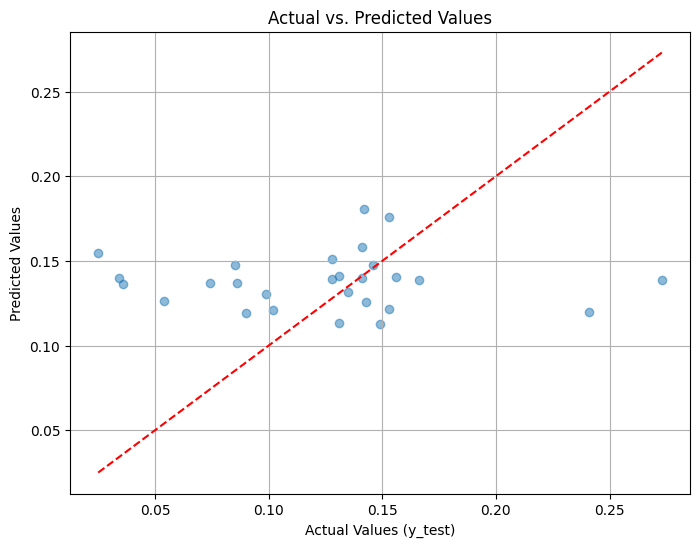

In [ ]:

df= arakawa
result_df_sorted, random_forest, r2 = RF_hold_out(df, prop, depth_opt, 300, 0.2, 3, "sqrt")

# result_df_sorted, random_forest, r2 = RF_hold_out(df, prop, 5, 100, 0.2, 100, 0.8)

C:\Users\46705\AppData\Local\Temp\ipykernel_1300\3583752957.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  features_df = features_df.applymap(lambda x: pd.to_numeric(x, errors='coerce'))


[[ 8.07163735  8.64615834  9.98759719 ...  5.65213682  0.
   0.        ]
 [ 6.06437181  6.559608    9.42885393 ... 10.54227689  4.8430456
   3.24999845]
 [ 7.82788132  4.73574961  9.2425234  ... 12.10321614  4.35229689
   2.93578927]
 ...
 [ 4.73789061  3.44638461  7.49681746 ... 10.2640716   3.32839786
   3.0331077 ]
 [ 8.63557939  7.46894857  9.36551229 ... 12.74684196  1.09693183
   2.71088439]
 [ 8.24953326  9.38537819  9.04213894 ... 10.37965473  1.83168179
   4.29630431]]
[1.72 0.96 0.94 0.63 0.5  1.27 0.94 1.12 1.02 0.66 1.34 0.76 2.4  1.18
 0.52 0.99 1.2  0.87 0.65 0.65 0.81 1.34 0.5  0.97 1.46 2.12 1.01 0.94
 0.89 0.7  0.8  0.64 2.52 1.03 1.04 1.1  1.23 1.56 0.97 1.68 1.01 1.4
 1.82 0.45 0.59 0.91 1.26 1.08 0.77 0.33 1.05 1.2  1.04 1.12 2.22 0.81
 0.76 1.   0.98 1.17 1.52 1.06 1.06 1.32 0.17 0.89 1.36 0.67 0.72 0.92
 1.25 0.54 1.54 1.12 0.64 0.71 2.17 1.63 1.56 0.92 0.36 2.06 0.98 0.82
 1.   1.97 1.2  0.74 1.66 1.79 1.16 1.53 2.45 0.75 2.21 1.25 1.08 1.63
 1.33 2.42 1.74 1.6  

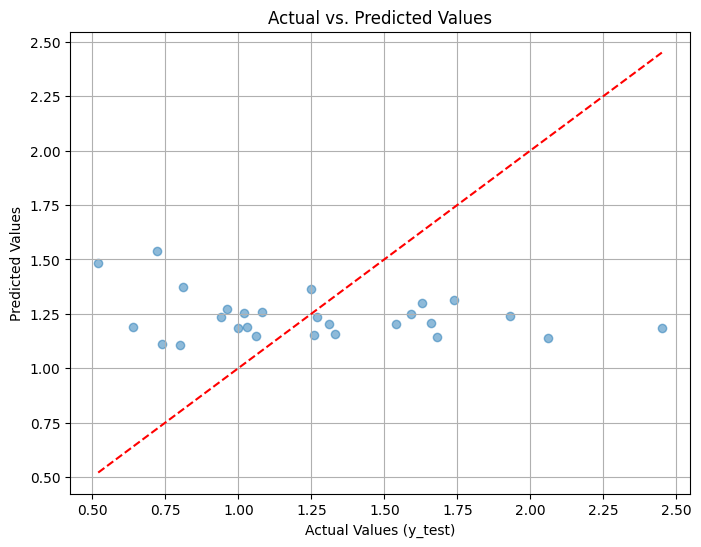

In [ ]:
features_df = df.iloc[4:, 7:-29]
properties_df = df.iloc[4:,:]["tensile_strength"]

features_df = features_df.applymap(lambda x: pd.to_numeric(x, errors='coerce'))
X = np.array(features_df)
y = np.array(properties_df)
features = features_df.columns
print(X)
print(y)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
y_test
random_forest = RandomForestRegressor(n_estimators=500, max_depth=3)

random_forest.fit(x_train, y_train)

y_pred = random_forest.predict(x_test)

r2 = r2_score(y_test, y_pred)

evaluate_regression(y_test, y_pred)